<a href="https://colab.research.google.com/github/aldofranco91/Trading/blob/main/Conv_Regression_ResNet_Jaime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!rm -rf backup/

In [2]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 11.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [96]:
import matplotlib
# importing the requests library 
import requests 
import pandas as pd
import numpy as np
import time
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display

import tensorflow as tf

from sklearn import metrics
from scipy import stats

tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
pd.set_option("display.max_columns", None)

import warnings
warnings.filterwarnings('ignore')

# Get data

In [261]:
import yfinance as yf
import datetime as dt

start = dt.datetime(2018,2,1)
end = dt.datetime(2022,1,31)

df = yf.download('BTC-USD', start, end).drop('Adj Close', axis=1)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,9959400448
2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,12726899712
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984
...,...,...,...,...,...
2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465
2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,20288500328
2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,19155189416


# Indicators

https://www.ig.com/es/estrategias-de-trading/los-10-mejores-indicadores-de-trading-para-inversores-190830

In [262]:
price = 'Close'

# MovingAverage
#https://towardsdatascience.com/building-a-comprehensive-set-of-technical-indicators-in-python-for-quantitative-trading-8d98751b5fb
values_ma = range(2,30,2)
for i in values_ma:
    df["maclose" + str(i)] = df[price].rolling(window=i).mean()

# ExponentialMovingWindow
values_ema = range(2,30,2)
for i in values_ema:
    df["ema" + str(i)] = df[price].ewm(span = i, adjust = False).mean()

# Wight Moving Average
# https://predictivehacks.com/?all-tips=how-to-apply-a-rolling-weighted-moving-average-in-pandas
weights = np.array([0.1, 0.2, 0.3, 0.4]) #Tienen que sumar 1 🙂
df['wma'] = df[price].rolling(4).apply(lambda x: np.sum(weights*x))

# RSI
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
values_rsi = range(2,30,2)
close = df[price]

# Get the difference in price from previous step
delta = close.diff()

# Make the positive gains (up) and negative gains (down) Series
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0

for i in values_rsi:
    # Calculate the EWMA
    roll_up1 = up.ewm(span=i).mean()
    roll_down1 = down.abs().ewm(span=i).mean()

    ## Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(i).mean()
    roll_down2 = down.abs().rolling(i).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))

    df["rsiewma" + str(i)] = RSI1.values
    df["rsisma" + str(i)]  = RSI2.values

# BollingerBand
values_bollinger = range(2,30,2)
for i in values_bollinger:
    df['bollingerupper' + str(i)] = df[price].rolling(window=i).mean() + (df[price].rolling(window=i).std() * 2)
    df['bollingerlower' + str(i)] = df[price].rolling(window=i).mean() - (df[price].rolling(window=i).std() * 2)

In [263]:
df = df.dropna()
df.tail(5)

,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-31,37920.281250,38647.261719,36733.574219,38483.125000,20734730465,38200.363281,38080.809570,37718.932292,37490.240723,37122.898047,37363.892904,38034.762556,38615.694092,39118.233507,39533.443750,39782.999645,39952.980632,40138.091046,40466.319475,38296.798762,38045.643919,37924.940763,37957.366542,38098.027527,38304.943894,38550.838508,38819.201467,39100.188163,39387.930387,39678.877145,39970.789293,40262.146598,40551.812231,38174.599609,89.522111,71.940251,83.091460,87.649925,73.471863,85.167683,64.314749,88.690510,57.518422,68.333563,52.674213,34.918420,49.180502,33.716543,46.607679,31.215557,44.675881,34.296059,43.202299,36.414490,42.064764,39.708384,41.179548,40.962039,40.487887,36.631200,39.947608,31.801033,39000.134196,37400.592366,38691.475677,37470.143464,38949.241912,36488.622671,38840.833397,36139.648049,39163.241259,35082.554835,40177.415808,34550.369999,42323.337000,33746.188111,43726.314930,33505.073254,44739.909896,33496.557118,45449.828792,33617.058708,45644.684589,33921.314700,45671.452069,34234.509194,45795.031037,34481.151054,46453.123769,34479.515182
2022-02-01,38481.765625,39115.132812,38113.664062,38743.273438,20288500328,38613.199219,38320.544922,38034.124349,37751.358887,37494.200391,37202.464193,37775.308315,38342.531250,38876.209852,39273.152344,39643.091087,39828.369466,39968.181190,40210.808733,38594.448546,38324.695726,38158.750098,38132.012519,38215.344965,38372.379208,38576.496499,38810.268758,39062.618192,39326.534487,39597.520301,39872.588025,40149.637475,40427.085418,38439.585156,95.019101,100.000000,87.866634,84.245519,78.233981,90.542498,68.742677,88.204952,61.435769,92.600620,56.102120,40.322129,52.190969,34.481511,49.271832,32.781691,47.052789,33.026415,45.338962,32.291436,43.998381,40.853724,42.939782,41.252521,42.098665,38.296684,41.428463,33.446911,38981.104667,38245.293770,39051.527921,37589.561922,39163.341471,36904.907227,39169.215528,36333.502245,39158.804075,35829.596707,39322.446784,35082.481601,41304.962124,34245.654506,42860.138077,33824.924423,44135.329904,33617.089801,44817.964233,33728.340454,45447.563434,33838.618740,45515.107114,34141.631819,45511.659120,34424.703260,45835.814834,34585.802633
2022-02-02,38743.714844,38834.617188,36832.730469,36952.984375,19155189416,37848.128906,38024.246094,38003.249349,37751.231445,37561.818359,37243.769857,37433.069475,38011.433350,38530.409071,38991.223047,39380.233310,39621.760417,39791.068960,39974.522321,37500.139099,37776.011186,37814.245606,37870.006264,37985.824858,38154.010773,38360.028215,38591.764713,38840.551474,39100.482095,39367.560655,39639.019733,39912.848356,40187.492242,37892.560937,8.031268,12.687460,20.727320,29.108426,28.662266,47.585680,32.767559,49.987933,34.599809,56.897428,35.304493,53.271606,35.494768,31.374486,35.468526,30.550395,35.366096,28.603712,35.252069,31.367900,35.154887,33.666192,35.085833,36.746687,35.048148,37.920440,35.041418,34.301312,40379.9

# Create sequences

In [264]:
#columns = ["prices", "total_volumes", "market_caps", "ema_5", "ema_10", "ema_15", "ema_30"]
columns = df.columns

df_rs = np.array(df[columns])
df_rs.shape

(1437, 90)

In [265]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    range = np.arange(start = 0, stop = len(sequence), step = 1) # Ojo con el step que te fundio :)
    for i in range:
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix][:,df.columns.get_loc(price)]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [266]:
past_t = 100
forecast_t = 5
n_steps_in = past_t
n_steps_out = forecast_t
# split into samples
X, y = split_sequence(df_rs, n_steps_in, n_steps_out)
print("Shape X --> " + str(X.shape))
print("Shape y --> " + str(y.shape))

print("Example of day -->")
pd.DataFrame(X[-1], columns=columns)

Shape X --> (1333, 100, 90)
Shape y --> (1333, 5)
Example of day -->


,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,60694.628906,61743.878906,59826.523438,61393.617188,2.688255e+10,61042.941406,62572.222656,62762.826823,62377.844727,61793.823047,60948.365560,60259.768136,59535.801514,58985.569878,58118.398633,57194.518821,56257.802083,55107.159856,54222.515206,61436.952535,61860.726031,61838.094819,61511.413861,61020.526520,60448.449537,59846.124300,59244.471587,58661.242603,58105.630375,57581.456469,57089.324473,56628.031637,56195.465511,61806.444531,46.227751,31.602978,39.808101,31.453110,44.482920,49.233800,48.964950,49.151448,52.555095,62.355885,55.322385,60.308027,57.414371,64.689992,58.972892,66.471786,60.118898,67.371274,60.950264,70.777966,61.543776,70.336120,61.958491,75.295211,62.239259,73.405134,62.419860,72.029245,62034.802298,60051.080515,67298.747141,57845.698172,66731.770310,58793.883336,66039.730224,58715.959230,66326.985953,57260.660140,66670.707046,55226.024074,66670.336661,53849.199612,66705.416804,52366.186223,66462.107642,51509.032115,67013.236670,49223.560595,67556.650805,46832.386837,68087.855036,44427.749131,69066.728473,41147.591238,69145.889385,39299.141028
1,61368.343750,61505.804688,59643.343750,60930.835938,2.731618e+10,61162.226562,61306.722656,62580.286458,62382.676758,62154.754297,61355.847005,60699.715123,59970.988281,59294.980252,58709.295312,57795.398260,56971.966309,55872.401893,54855.454381,61099.541470,61488.769993,61578.877996,61382.396545,61004.219142,60522.662829,59990.752519,59442.867393,58900.147164,58374.697572,57872.706857,57396.645391,56946.757882,56522.042782,61149.889844,25.601264,60.246697,33.119613,10.848937,39.899094,44.750293,45.282285,50.167121,49.422372,60.911154,52.581828,63.598453,54.976404,63.912241,56.778782,64.920820,58.126514,61.116338,59.127666,68.879089,59.865892,70.212811,60.405194,72.894821,60.794131,74.753856,61.069353,70.917551,61816.698083,60507.755042,62644.690976,59968.754336,66804.417759,58356.155158,66035.691675,58729.661840,65532.925574,58776.583020,66179.102425,56532.591586,66279.358594,55120.071652,66516.755327,53425.221236,66595.193068,51994.767436,66598.513072,50820.077553,67355.247873,48235.548647,67676.586258,46267.346359,68763.241445,42981.562341,69337.881353,40373.027408
2,60893.925781,63729.324219,60691.800781,63039.824219,3.106491e+10,61985.330078,61514.135742,62376.591797,62568.452637,62299.341797,61825.740885,61096.503348,60475.463379,59807.971354,59285.545898,58469.937855,57593.753092,56698.381160,55598.457729,62393.063302,62109.191684,61996.291202,61750.713806,61374.329156,60909.918428,60397.295412,59866.038784,59335.902644,58818.995348,58322.021410,57848.099697,57398.096129,56971.544950,61843.130469,89.521560,82.005337,70.616955,58.658397,63.738885,44.069757,62.019427,55.710510,62.029194,55.028740,62.568563,65.054174,63.194422,62.899555,63.745443,66.511919,64.173863,68.032040,64.477958,68.585082,64.673074,71.619266,64.779059,71.188332,64.815014,75.708377,64.797400,73.913606,64967.889908,59002.770248,63630.093902,59398.177582,66320.011456,58433.172138,66179.650149,58957.255125,65694.559585,58904.124

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

scaler = MinMaxScaler(feature_range=(-1,1)) #Try this
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_new = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

print("Shape X_train --> " + str(X_train.shape))
print("Shape y_train --> " + str(y_train.shape))
print("Shape X_test  --> " + str(X_test.shape))
print("Shape y_test  --> " + str(y_test.shape))
print("Example of day -->")
pd.DataFrame(X_train[-1], columns=columns)

Shape X_train --> (1066, 100, 90)
Shape y_train --> (1066, 5)
Shape X_test  --> (267, 100, 90)
Shape y_test  --> (267, 5)
Example of day -->


,Open,High,Low,Close,Volume,maclose2,maclose4,maclose6,maclose8,maclose10,maclose12,maclose14,maclose16,maclose18,maclose20,maclose22,maclose24,maclose26,maclose28,ema2,ema4,ema6,ema8,ema10,ema12,ema14,ema16,ema18,ema20,ema22,ema24,ema26,ema28,wma,rsiewma2,rsisma2,rsiewma4,rsisma4,rsiewma6,rsisma6,rsiewma8,rsisma8,rsiewma10,rsisma10,rsiewma12,rsisma12,rsiewma14,rsisma14,rsiewma16,rsisma16,rsiewma18,rsisma18,rsiewma20,rsisma20,rsiewma22,rsisma22,rsiewma24,rsisma24,rsiewma26,rsisma26,rsiewma28,rsisma28,bollingerupper2,bollingerlower2,bollingerupper4,bollingerlower4,bollingerupper6,bollingerlower6,bollingerupper8,bollingerlower8,bollingerupper10,bollingerlower10,bollingerupper12,bollingerlower12,bollingerupper14,bollingerlower14,bollingerupper16,bollingerlower16,bollingerupper18,bollingerlower18,bollingerupper20,bollingerlower20,bollingerupper22,bollingerlower22,bollingerupper24,bollingerlower24,bollingerupper26,bollingerlower26,bollingerupper28,bollingerlower28
0,-0.975318,-0.975694,-0.974116,-0.975261,-0.961365,-0.975348,-0.975965,-0.978876,-0.980987,-0.981542,-0.982422,-0.984040,-0.985857,-0.986383,-0.986944,-0.987512,-0.987607,-0.987634,-0.987693,-0.975503,-0.976576,-0.978258,-0.980154,-0.982107,-0.984114,-0.984743,-0.985357,-0.985962,-0.986560,-0.987148,-0.987729,-0.988306,-0.988883,-0.975292,0.405856,-0.52700,0.518710,0.697073,0.525234,0.703968,0.499738,0.343625,0.466195,0.428503,0.436029,0.437886,0.414002,0.646230,0.396659,0.307942,0.380296,0.343132,0.361288,0.360578,0.344836,0.391126,0.330039,-0.006890,0.316205,-0.006877,0.302823,0.060781,-0.976789,-0.945868,-0.977372,-0.968504,-0.982504,-0.968950,-0.982683,-0.967625,-0.983321,-0.968242,-0.985100,-0.968822,-0.986824,-0.970003,-0.986977,-0.970930,-0.987626,-0.970833,-0.988633,-0.970987,-0.989838,-0.972291,-0.989062,-0.971250,-0.989149,-0.966126,-0.989280,-0.962484
1,-0.975233,-0.975369,-0.973651,-0.974058,-0.963101,-0.974630,-0.975088,-0.977995,-0.980316,-0.981190,-0.981983,-0.983627,-0.985392,-0.985991,-0.986575,-0.987224,-0.987707,-0.987482,-0.987544,-0.974614,-0.975814,-0.977555,-0.979507,-0.981508,-0.983555,-0.984217,-0.984857,-0.985483,-0.986098,-0.986701,-0.987295,-0.987884,-0.988471,-0.974599,0.889628,1.00000,0.758590,0.701196,0.698136,0.777773,0.645338,0.756258,0.595858,0.379831,0.553477,0.495855,0.520796,0.526710,0.494272,0.405326,0.469806,0.389573,0.443505,0.424792,0.420828,0.345985,0.400703,-0.124568,0.382283,0.081101,0.364931,0.067215,-0.974812,-0.946536,-0.977634,-0.966403,-0.981943,-0.967748,-0.981742,-0.967268,-0.982395,-0.968548,-0.984230,-0.968903,-0.985993,-0.970087,-0.986255,-0.970781,-0.986867,-0.970882,-0.987894,-0.971066,-0.989093,-0.972548,-0.989617,-0.970818,-0.988706,-0.966323,-0.988866,-0.962654
2,-0.974048,-0.975148,-0.973420,-0.973552,-0.958326,-0.973771,-0.974780,-0.977121,-0.979596,-0.980747,-0.981472,-0.983194,-0.984714,-0.985577,-0.986185,-0.986867,-0.987317,-0.987375,-0.987438,-0.973975,-0.975147,-0.976901,-0.978885,-0.980921,-0.982999,-0.983689,-0.984352,-0.984998,-0.985629,-0.986245,-0.986851,-0.987452,-0.988050,-0.974049,0.945596,1.00000,0.821835,0.451932,0.752825,0.776328,0.695311,0.769343,0.642644,0.474991,0.597346,0.569456,0.561695,0.540095,0.532354,0.692100,0.505216,0.404120,0.476378,0.441080,0.451466,0.443901,0.429381,0.448395,0.409245,0.047050,0.390383,0.034390,-0.974935,-0.944692,-0.976772,-0.966719,-0.981835,-0.966063,-0.981009,-0.966579,-0.981461,-0.968670,-0.983449,-0.968724,-0.985184,-0.970103,-0.986146,-0.969467,-0.986116,-0.970876,-0.987159,-0.971096,-0.988362,-0.972644,-0.988969,-0.970745,-0.988340,-0.966527,-0.988514,-0.962845
3,-0.973639,-0.974907,-0.974242,-0.975359,-0.954560,-0.974425,-0.974747,-0.976754,-0.979101,-0.980342,-0.981290,-0.982916,-0.984438,-0.985239,-0.985900,-0.986594,-0.987111,-0.987522,-0.987347,-0.974985,-0.975496,-0.976974,-0.978824,-0.980787,-0.982824,-0.983488,-0.984134,-0.984767,-0.985389,-0.985999,-0.986601,-0.987198,-0.987794,-0.974365,-0.697763,-0.56241,-0.285892,0.034037,-0.071098,0.295267,0.04

# Model 

Transfer learning work-flow

https://keras.io/guides/transfer_learning/ (The typical transfer-learning workflow)

In [33]:
from tensorflow.keras import backend as K 

def euc_dist_keras(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_true - y_pred), axis=-1, keepdims=True))

def max_distance(y_true, y_pred):
    return K.max(K.abs(y_true - y_pred), axis=-1, keepdims=True)

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import activations

In [41]:
# Load Resnet model
image_shape = X_train.shape[1]

base_model = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(image_shape, image_shape, 3),
    include_top=False) 
base_model.trainable = False

# Create input as image

inputs = layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_img = layers.Dense(image_shape, activation='tanh')(inputs) # Create a square matrix 
input_img = layers.Reshape((image_shape, image_shape, 1))(input_img) # Reshape into an image with 1 channels
input_img = layers.Dense(3, activation='tanh', name='image_inp')(input_img) # Learn 3 channels
# With tahn all outputs are between -1 and 1 (ResNet needs that)

# Create Model
x = base_model(input_img, training=False)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x) 

# Output layer
predictions = layers.Dense(y_train.shape[1], activation="relu")(x) #Relu for getting positive values
model = tf.keras.Model(inputs, predictions)

model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 90)]         0         
                                                                 
 dense_4 (Dense)             (None, 100, 100)          9100      
                                                                 
 reshape_2 (Reshape)         (None, 100, 100, 1)       0         
                                                                 
 dense_5 (Dense)             (None, 100, 100, 3)       6         
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

In [37]:
#tf.keras.utils.plot_model(model, to_file="model.png")

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=15, verbose=1, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=1, factor=0.5, min_lr=5e-5)

In [43]:
history = model.fit(X_train, y_train, epochs = 500, batch_size = 16, 
                    callbacks=[learning_rate_reduction, early_stopping],
                    validation_data= (X_test, y_test))

Epoch 1/500
67/67 [==============================] - 24s 185ms/step - loss: 19790.7324 - mae: 19790.7324 - val_loss: 16782.4258 - val_mae: 16782.4258 - lr: 0.0100
Epoch 2/500
67/67 [==============================] - 10s 144ms/step - loss: 18083.7422 - mae: 18083.7422 - val_loss: 14883.0918 - val_mae: 14883.0918 - lr: 0.0100
Epoch 3/500
67/67 [==============================] - 10s 143ms/step - loss: 16316.5625 - mae: 16316.5625 - val_loss: 13639.4590 - val_mae: 13639.4590 - lr: 0.0100
Epoch 4/500
67/67 [==============================] - 10s 143ms/step - loss: 14954.7314 - mae: 14954.7314 - val_loss: 12286.3477 - val_mae: 12286.3477 - lr: 0.0100
Epoch 5/500
67/67 [==============================] - 10s 151ms/step - loss: 14103.8047 - mae: 14103.8047 - val_loss: 11646.8857 - val_mae: 11646.8857 - lr: 0.0100
Epoch 6/500
67/67 [==============================] - 9s 128ms/step - loss: 13519.8848 - mae: 13519.8848 - val_loss: 11731.8066 - val_mae: 11731.8066 - lr: 0.0100
Epoch 7/500
67/67 [====

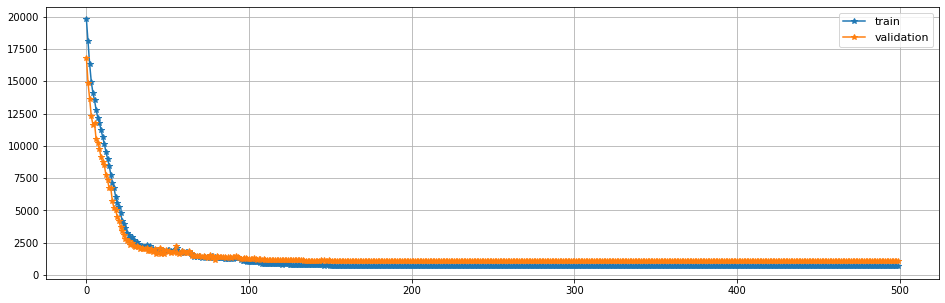

In [45]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

## Fine-tuning

In [239]:
checkpoint = ModelCheckpoint('backup/modelo_best.h5', monitor="val_loss",
                             save_freq = 'epoch', save_best_only=True, mode='min') 

In [240]:
# Unfreeze the base model
base_model.trainable = True

# Very low learning rate
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics='mae') 

history = model.fit(X_train, y_train, epochs = 50, batch_size = 16,
                    validation_data= (X_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/15
67/67 [==============================] - 84s 265ms/step - loss: 964.1893 - mae: 964.1893 - val_loss: 799.2164 - val_mae: 799.2164
Epoch 2/15
67/67 [==============================] - 15s 229ms/step - loss: 837.3366 - mae: 837.3366 - val_loss: 735.9684 - val_mae: 735.9684
Epoch 3/15
67/67 [==============================] - 15s 225ms/step - loss: 853.0123 - mae: 853.0123 - val_loss: 678.3660 - val_mae: 678.3660
Epoch 4/15
67/67 [==============================] - 12s 175ms/step - loss: 853.1663 - mae: 853.1663 - val_loss: 765.3810 - val_mae: 765.3810
Epoch 5/15
67/67 [==============================] - 12s 186ms/step - loss: 838.2840 - mae: 838.2840 - val_loss: 722.3116 - val_mae: 722.3116
Epoch 6/15
67/67 [==============================] - 18s 273ms/step - loss: 775.6450 - mae: 775.6450 - val_loss: 656.0189 - val_mae: 656.0189
Epoch 7/15
67/67 [==============================] - 14s 213ms/step - loss: 732.6910 - mae: 732.6910 - val_loss: 670.8647 - val_mae: 670.8647
Epoch 8/15
67

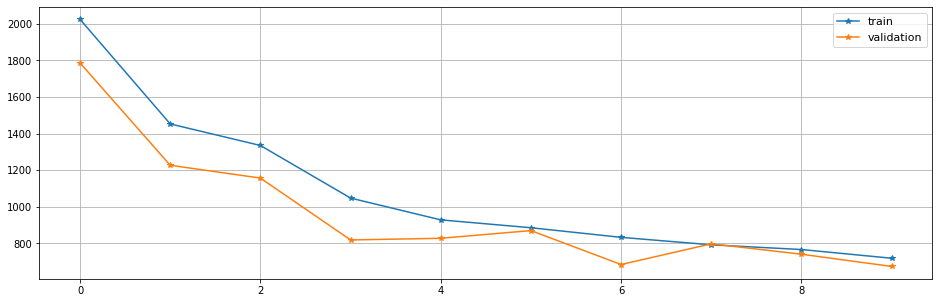

In [194]:
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train', marker='*')
plt.plot(history.history['val_loss'], label='validation', marker='*')
plt.grid()
plt.legend(fontsize=11)

In [241]:
best_model = tf.keras.models.load_model('/content/backup/modelo_best.h5')
best_model.evaluate(X_test, y_test)

9/9 [==============================] - 3s 78ms/step - loss: 584.2658 - mae: 584.2658


[584.2658081054688, 584.2658081054688]

# Images created 

In [244]:
sub_model = tf.keras.Model(inputs=best_model.input, outputs=best_model.get_layer('image_inp').output)
sub_model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics='mae')
layer_output = sub_model.predict(X_new, verbose=1)

42/42 [==============================] - 0s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Image Input 1000')

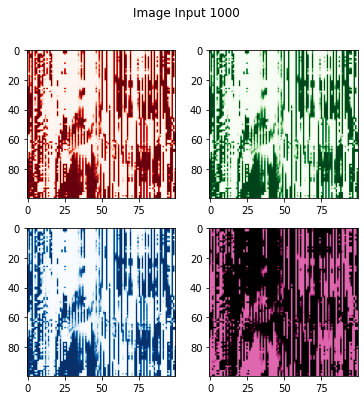

In [245]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs[0,0].imshow(layer_output[1000][:,:,0], cmap='Reds')
axs[0,1].imshow(layer_output[1000][:,:,1], cmap='Greens')
axs[1,0].imshow(layer_output[1000][:,:,1], cmap='Blues')
axs[1,1].imshow(layer_output[1000])
fig.suptitle('Image Input 1000', fontsize=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


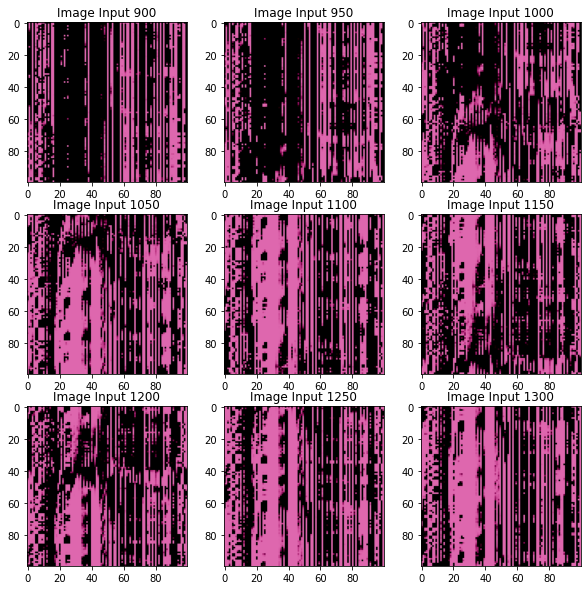

In [246]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for idx,i in enumerate(range(900,len(layer_output),50)):
  axs.flat[idx].imshow(layer_output[i])
  axs.flat[idx].set_title('Image Input ' + str(i))

# Results

In [248]:
y_pred_test = best_model.predict(X_test, verbose=1)
y_pred_redes = best_model.predict(X_new, verbose=1)

42/42 [==============================] - 3s 71ms/step


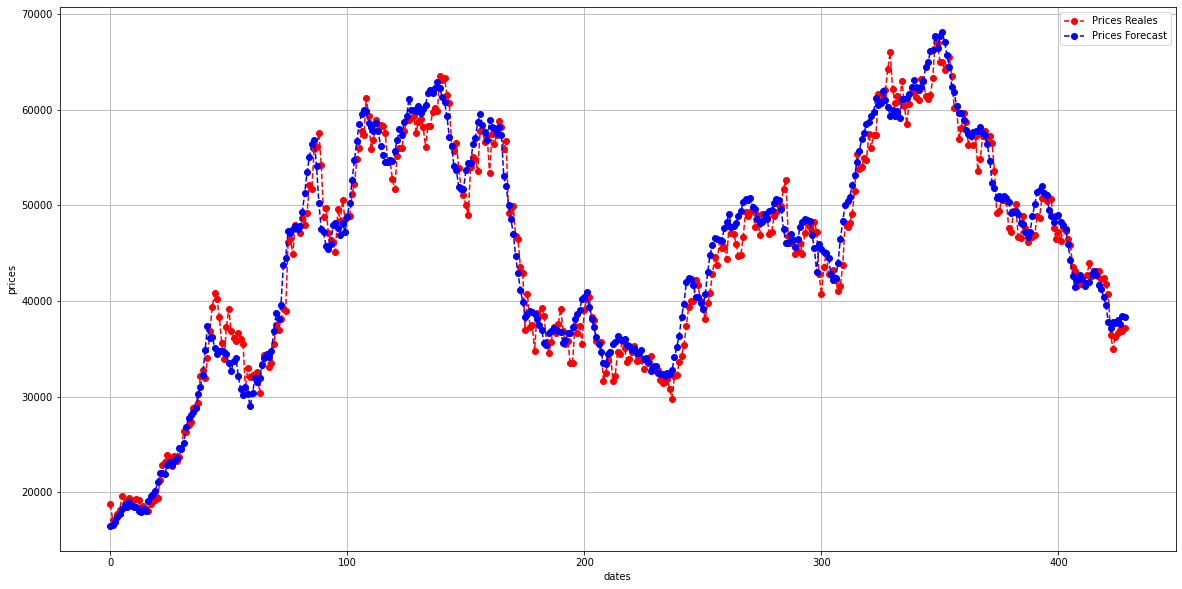

In [252]:
c = 900
day_pred = 0

fig=plt.figure(figsize=(20, 10))
plt.plot(y[c:, day_pred], '--bo', label = 'Prices Reales', color = "r")
plt.plot(y_pred_redes[c:, day_pred], '--bo', label = 'Prices Forecast', color = "b")
plt.xlabel('dates')
plt.ylabel('prices')
plt.legend()
plt.grid(True)
plt.savefig('imagen.png', dpi = 200)
plt.show()

In [253]:
y_test_original = y_test
y_pred_test = y_pred_test

y_original = y
y_pred_full = y_pred_redes

In [254]:
errores_test = np.empty([len(y_test)])
for i in range(0,len(y_test)):
    errores_test[i] = np.linalg.norm(y_test_original[i] - y_pred_test[i], np.inf)

errores_full = np.empty([len(y)])
for i in range(0,len(y)):
    errores_full[i] = np.linalg.norm(y_original[i] - y_pred_full[i], np.inf)

In [255]:
print("Errores Test")
print(pd.DataFrame(errores_test).describe().transpose().round(2))
print("Errores Full")
print(pd.DataFrame(errores_full).describe().transpose().round(2))

Errores Test
   count     mean      std    min     25%     50%      75%      max
0  266.0  1108.26  1346.54  37.26  250.94  469.59  1588.23  7074.14
Errores Full
    count    mean      std    min     25%    50%      75%      max
0  1329.0  1235.8  1431.02  19.11  292.94  543.4  1802.19  8409.01


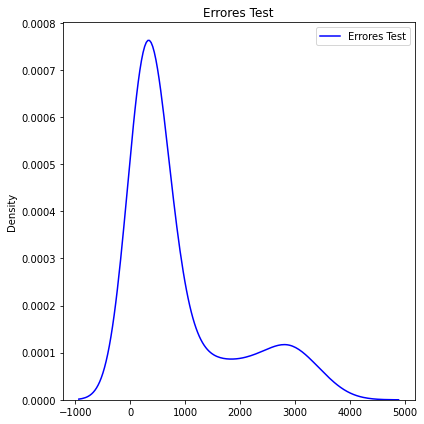

In [256]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_test[errores_test < np.percentile(errores_test, 95)], color = "blue", label = 'Errores Test')
plt.title('Errores Test')
plt.tight_layout()
plt.legend()
plt.show()

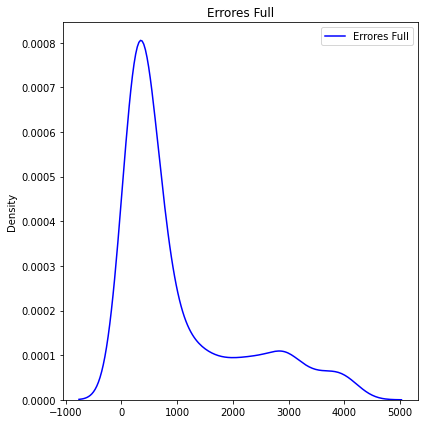

In [257]:
plt.figure(figsize=(6,6))
sns.kdeplot(errores_full[errores_full < np.percentile(errores_full, 95)], color = "blue", label = 'Errores Full')
plt.title('Errores Full')
plt.tight_layout()
plt.legend()
plt.show()

In [258]:
best_redes_test = np.argmin(errores_test)
worse_redes_test = np.argmax(errores_test)

best_redes_full = np.argmin(errores_full)
worse_redes_full = np.argmax(errores_full)

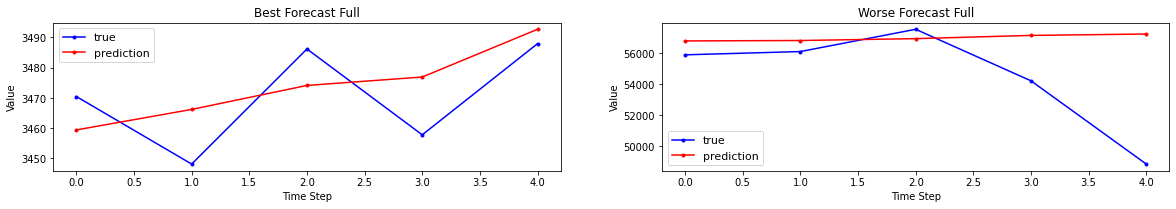

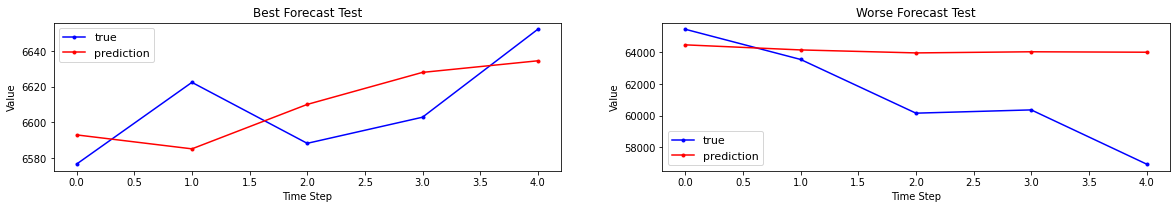

In [260]:
plt.figure(figsize=(20, 6))
plt.subplot(221)
plt.title("Best Forecast Full")
plt.plot(y_original[best_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[best_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(222)
plt.title("Worse Forecast Full")
plt.plot(y_original[worse_redes_full], color = "blue", marker='.', label="true")
plt.plot(y_pred_full[worse_redes_full], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.figure(figsize=(20, 6))
plt.subplot(223)
plt.title("Best Forecast Test")
plt.plot(y_test_original[best_redes_test],  color = "blue", marker='.', label="true")
plt.plot(y_pred_test[best_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11)

plt.subplot(224)
plt.title("Worse Forecast Test")
plt.plot(y_test_original[worse_redes_test], color = "blue", marker='.', label="true")
plt.plot(y_pred_test[worse_redes_test], color = 'red', marker = ".", label="prediction")
plt.ylabel('Value'); plt.xlabel('Time Step'); plt.legend(fontsize=11) 
plt.show();
